In [19]:
import torch
print(torch.__version__)
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image
import sys
from os.path import join
sys.path.append("../pytorch-unet-segmentation-master/src/")
from save_history import *
from modules import *
from dataset import *
import ipywidgets as widgets
import cv2
from tqdm.notebook import tqdm

1.5.0


Load Claudio data

In [13]:
from czifile import CziFile
with CziFile(join("../pytorch-unet-segmentation-master/test2/test2.czi")) as czi:
    image_arrays = czi.asarray()
    meta = czi.metadata(raw=False)

In [20]:
def normalize_image(img):
    img = (img/img.max())*255
    return img.astype('uint8')

def denoise_image(img, h=30):
    # Filtro mediana para eliminar ruido impulsivo
    img = cv2.medianBlur(img, 5)
    # Non-local mean denoising http://www.ipol.im/pub/art/2011/bcm_nlm/
    img = cv2.fastNlMeansDenoising(img, None, h=h, templateWindowSize=7, searchWindowSize=21)
    return img
def get_binary_mask(img):
    # Adaptive thresholding    
    binary_mask = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 21, 0)
    # Cerradura morfologica
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, 
                                   kernel=np.ones((3,3),np.uint8), iterations = 4)
    return binary_mask
def get_markers(dist, threshold=0.3):
    ret, sure_fg = cv2.threshold(dist, threshold*dist.max(), 255, 0)
    ret, markers = cv2.connectedComponents(sure_fg.astype('uint8'))
    return markers
def watershed_pipeline(img, th=0.1):
    #img = denoise_image(img)
    #binary_mask = ~get_binary_mask(img)
    dist_transform = cv2.distanceTransform(img, cv2.DIST_L2, 5)
    markers = get_markers(dist_transform, threshold=th)
    watershed =  cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers.copy())
    return markers, watershed

z = 0

Create PNG images

In [22]:
import matplotlib.pyplot as plt

for x in range (0, 60):
    img = image_arrays[0, 0, 0, x, 0, :, :, 0]
    plt.imsave(join("../pytorch-unet-segmentation-master/Claudio_png", "test", str(x)+".png"), img, cmap='gray_r') #guarda en escala de grises invertido

In [25]:
r = c = 190
w = h = 388

model = torch.load('../pytorch-unet-segmentation-master/modelos/model_epoch_440.pwf', map_location=torch.device('cpu')).module.cpu()
model.eval()

original=[]
preprocesada=[]
for x in range (0, 60):
    i = cv2.imread('../pytorch-unet-segmentation-master/Claudio_png/test/'+str(x)+'.png', cv2.IMREAD_GRAYSCALE)[r:r+h, c:c+w]
    original.append(i)
    i_p= cv2.bilateralFilter(i, 5, 75, 75)
    i_p= cv2.equalizeHist(i_p)
    preprocesada.append(i_p)
    plt.imsave(join("../pytorch-unet-segmentation-master/preprocesada","test", str(x)+".png"), i_p, cmap='gray')

Text(0.5,1,'Preprocesada')

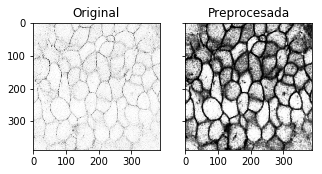

In [26]:
img_num=5
fig, ax = plt.subplots(1, 2, figsize=(5, 5), sharex=True, sharey=True)
ax[0].imshow(original[img_num], cmap=plt.cm.Greys_r)
ax[0].set_title('Original')
ax[1].imshow(preprocesada[img_num], cmap=plt.cm.Greys_r)
ax[1].set_title('Preprocesada')

## Torch dataset para las imágenes de Claudio

- El dataset lo creo con ImageFolder. Las imágenes deben estar en "Claudio_png/test"
- Le aplico transforms para llevarlo a escala de grises e imitar el crop/padding que se usaba nates
- Finalmente le aplico una transformación custom para "corregir la imagen"

> El objetivo es que las imágenes de Claudio se vean más parecidas a las del challenge

<IPython.core.display.Javascript object>


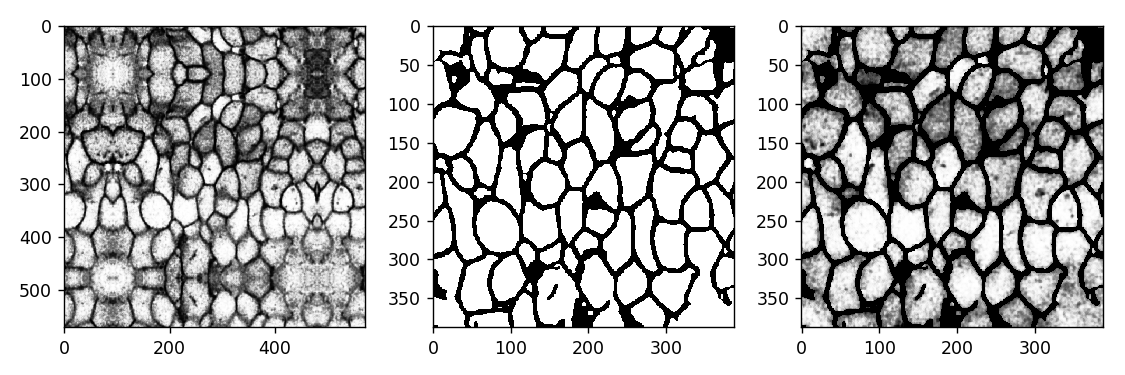

In [27]:
import torchvision
import torchvision.transforms.functional as TF

# https://pytorch.org/docs/stable/torchvision/transforms.html
#equ = cv2.equalizeHist(img)
class ImproveImageTransform:
    
    def __init__(self, contrast_factor=1, brightness_factor=1, saturation_factor=1):
        self.saturation_factor= saturation_factor # 0 will give a black and white image,1 will give the original image while 2 will enhance the saturation by a factor of 2.
        self.contrast_factor = contrast_factor
        self.brightness_factor = brightness_factor

    def __call__(self, x):
        #x = TF.adjust_gamma(x, gamma=1)
        x = TF.adjust_saturation(x, self.saturation_factor)
        x = TF.adjust_brightness(x, self.brightness_factor)
        x = TF.adjust_contrast(x, self.contrast_factor)
        return x

my_transforms = torchvision.transforms.Compose([torchvision.transforms.Grayscale(),
                                                torchvision.transforms.Pad(padding=(572-388)//2,
                                                                           padding_mode='reflect'),
                                                torchvision.transforms.ToTensor()])
               
claudio_dataset = torchvision.datasets.ImageFolder("../pytorch-unet-segmentation-master/preprocesada", transform=my_transforms)

claudio_loader = torch.utils.data.DataLoader(dataset=claudio_dataset, batch_size=1, 
                                             num_workers=0, shuffle=False)

img_list = []
water_list = []
kernel = np.ones((1, 1), np.uint8)
kernel1 = np.ones((3, 3), np.uint8)
for image, label in tqdm(claudio_loader):
    with torch.no_grad():
        output = model.forward(image)
        output = torch.argmax(output, dim=1).float()
        img = output[0].detach().numpy().astype('uint8')*255
        img_list.append(img)
        ret, bin_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        closing = cv2.morphologyEx(bin_image, cv2.MORPH_CLOSE, kernel, iterations=1)
        sure_bg = cv2.dilate(closing, kernel1, iterations=1)
        dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
        ret, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg, sure_fg)
        ret, markers = cv2.connectedComponents(sure_fg)
        markers_plus1 = markers + 1
        markers_plus1[unknown == 255] = 0
        watershed =  cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers_plus1.copy())
        water_list.append(watershed)
    

%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
pad = (572-388)//2
ax[0].imshow(image.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output.numpy()[0], cmap=plt.cm.Greys_r)

borders_on_top = image.numpy()[0, 0, pad:-pad, pad:-pad].copy()
idx = np.where(output.numpy()[0].astype(int) == 0)
borders_on_top[idx[0], idx[1]] = 0
ax[2].imshow(borders_on_top, cmap=plt.cm.Greys_r)

<IPython.core.display.Javascript object>


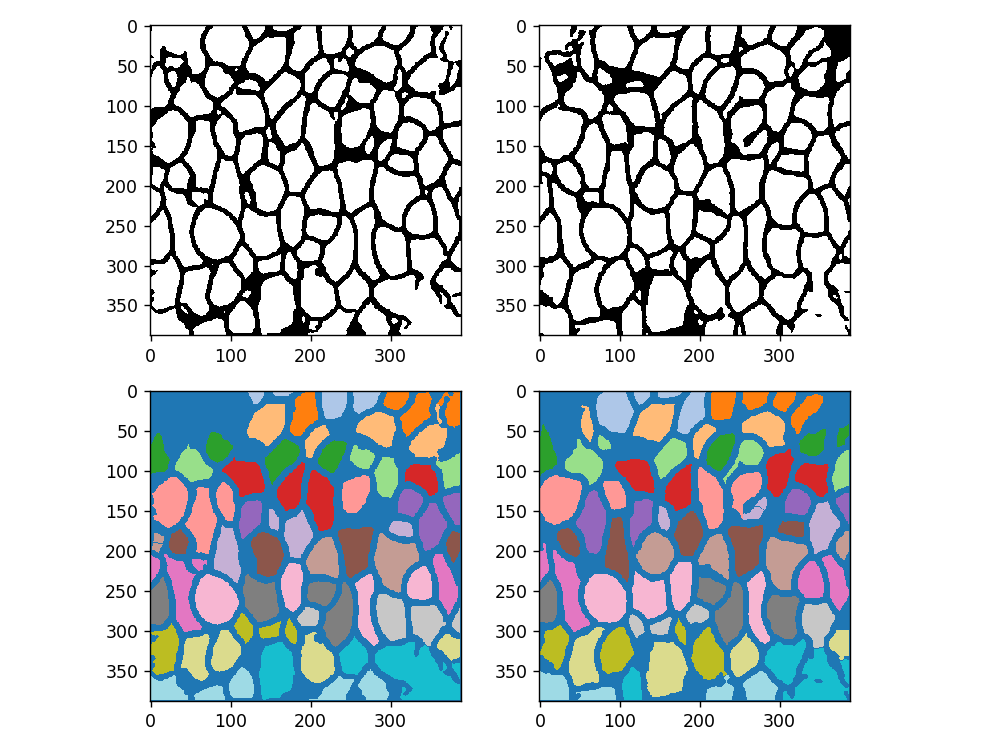

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0, 0].imshow(img_list[0], cmap=plt.cm.Greys_r)
ax[1, 0].imshow(water_list[0], cmap=plt.cm.tab20)
ax[0, 1].imshow(img_list[58], cmap=plt.cm.Greys_r)
ax[1, 1].imshow(water_list[58], cmap=plt.cm.tab20)

<IPython.core.display.Javascript object>


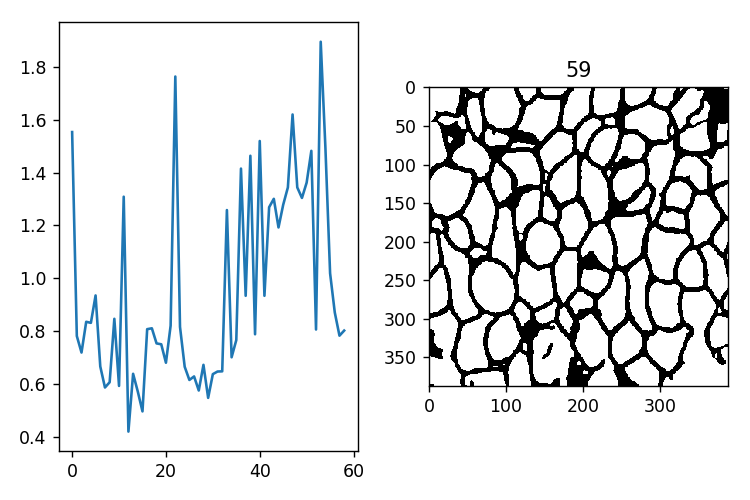

In [31]:
total_area = np.prod(watershed.shape)

cell_idx = 2
cell_coords = np.mean(np.where(water_list[0]==cell_idx), axis=1)
size_cell = []
cell_idx_history = [cell_idx]

for water in water_list[1:]:
    # Get coords of all cells
    new_cords = [np.mean(np.where(water==idx), axis=1) for idx in np.unique(water)[1:]]
    # Find nearest neightbor index
    closest_idx = np.argmin(np.sum((np.stack(new_cords) - cell_coords)**2, axis=1))
    
    #if distancias iguales, if celula desaparece, if distancia mayor a cierta cantidad de pixeles, 
    #medir distancia, if dos celulas se fusionan , if si dos tienen 2 celulas con misma next la que tenga menor
    nn_idx = np.unique(water)[1:][closest_idx]
    # Save index and area, agregar condiciones 
    cell_idx_history.append(nn_idx)
    size_cell.append(100*len(np.where(water == nn_idx)[0])/total_area)
    # update cell coords
    cell_coords = np.mean(np.where(water==nn_idx), axis=1)
    
#Adaptar visualizacion
# AGREGAR RESTRICCIONES #
#elimino los menores a 1
new_size_cell=[]
for size in size_cell:
    if (size<3):
        new_size_cell.append(size)
        
fig, ax = plt.subplots(1,2, figsize=(6, 4), tight_layout=True)
ax[0].plot(new_size_cell)

from matplotlib.animation import FuncAnimation

def update(k):
    ax[1].cla()
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 255
    ax[1].imshow(img, cmap=plt.cm.Greys_r)
    ax[1].set_title(k)
    
ani = FuncAnimation(fig, update, frames=range(60), repeat=False, interval=200)

In [101]:
new_size_cell

[1.553034328834095,
 0.7818312254224679,
 0.7193910086087788,
 0.8356360931023488,
 0.8316505473482836,
 0.9352747369539802,
 0.6669146561802529,
 0.5872037410989478,
 0.6071314698692741,
 0.8469284727388671,
 0.5931820597300457,
 1.3085875225847592,
 0.4204750770538846,
 0.6390158359017961,
 0.5719258157083643,
 0.496864704006802,
 0.8077372728238921,
 0.8110585609522797,
 0.753932405144011,
 0.7506111170156233,
 0.6808640663194814,
 0.8210224253374429,
 1.7629397385481986,
 0.8163726219577001,
 0.6655861409288979,
 0.6157668190030822,
 0.6290519715166331,
 0.5759113614624296,
 0.6728929748113508,
 0.5480125411839728,
 0.6376873206504411,
 0.6476511850356043,
 0.6483154426612817,
 1.2581039430332661,
 0.7014560527154852,
 0.7665533000318844,
 1.414868742693166,
 0.9339462217026252,
 1.4633595493676268,
 0.7884738016792433,
 1.5191571899245404,
 0.9339462217026252,
 1.2687320650441067,
 1.3006164310766288,
 1.1923424380911893,
 1.2780316718035922,
 1.343793176745669,
 1.619460091401849

In [81]:
size_cell

[1.0163141672866405,
 1.00834307577851,
 1.0090073334041876,
 0.9870868317568285,
 1.0116643639068976,
 1.0017004995217345,
 1.022956743543416,
 0.9957221808906366,
 1.0302635774258688,
 1.0276065469231588,
 1.0395631841853545,
 24.85984164098204,
 1.0681262620894887,
 1.076761611223297,
 1.0435487299394197,
 1.0063503029014773,
 0.9910723775108938,
 0.954538208098629,
 0.9791157402486981,
 0.9757944521203104,
 0.9811085131257307,
 0.9890796046338612,
 24.81334360718461,
 0.9997077266447019,
 1.0289350621745137,
 1.0302635774258688,
 1.00834307577851,
 1.0236210011690934,
 1.0395631841853545,
 1.0302635774258688,
 1.0282708045488362,
 1.0249495164204485,
 1.034249123179934,
 1.076761611223297,
 1.0382346689339994,
 1.0335848655542565,
 1.0295993198001914,
 1.0422202146880646,
 1.056169624827293,
 1.0780901264746519,
 1.0714475502178764,
 1.1232596450207248,
 1.1252524178977574,
 1.12724519077479,
 1.0395631841853545,
 24.822643213944097,
 24.69975555319375,
 25.112259538739504,
 24.934

<IPython.core.display.Javascript object>


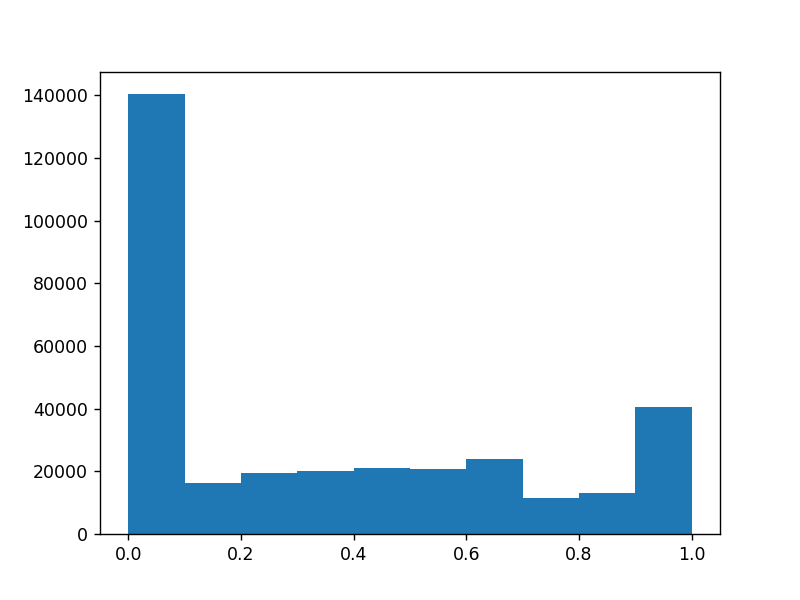

(array([140423.,  16390.,  19357.,  20235.,  21014.,  20895.,  24043.,
         11405.,  12954.,  40468.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

In [14]:
plt.figure()
plt.hist(image.numpy()[0, 0].ravel())

Alternative, adapt orignal code:

In [10]:
class ClaudioDataTest(Dataset):

    def __init__(self, image_path, in_size=572, out_size=388):
        '''
        Args:
            image_path = path where test images are located
            mask_path = path where test masks are located
        '''
        # paths to all images and masks

        self.image_arr = glob.glob(str(image_path) + str("/*"))
        self.in_size = in_size
        self.out_size = out_size
        self.data_len = len(self.image_arr)

    def __getitem__(self, index):
        '''Get specific data corresponding to the index
        Args:
            index: an integer variable that calls(indext)th image in the
                path
        Returns:
            Tensor: 4 cropped data on index which is converted to Tensor
        '''

        single_image = self.image_arr[index]
        img_as_img = Image.open(single_image)
        # img_as_img.show()
        # Convert the image into numpy array
        # OJO: ACA LA IMAGEN SE CORTA Y SE BOTAN LOS CANALES
        img_as_np = np.asarray(img_as_img)[:self.in_size, :self.in_size, 0]
        pad_size = int((self.in_size - self.out_size)/2)
        img_as_np = np.pad(img_as_np, pad_size, mode="symmetric")
        img_as_np = multi_cropping(img_as_np,
                                   crop_size=self.in_size,
                                   crop_num1=2, crop_num2=2)

        # Empty list that will be filled in with arrays converted to tensor
        processed_list = []

        for array in img_as_np:

            # SANITY CHECK: SEE THE PADDED AND CROPPED IMAGES
            # array_image = Image.fromarray(array)

            # Normalize the cropped arrays
            img_to_add = normalization2(array, max=1, min=0)
            # Convert normalized array into tensor
            processed_list.append(img_to_add)

        img_as_tensor = torch.Tensor(processed_list)
        #  return tensor of 4 cropped images
        #  top left, top right, bottom left, bottom right respectively.
        return img_as_tensor

    def __len__(self):

        return self.data_len
    
claudio_dataset = ClaudioDataTest("Claudio_png/test")
claudio_loader = torch.utils.data.DataLoader(dataset=claudio_dataset, batch_size=1, 
                                             num_workers=0, shuffle=False)

for images_t in claudio_loader:
    stacked_img = torch.Tensor([])
    
    for index in range(images_t.size()[1]):
        print(index)
        with torch.no_grad():
            image_t = Variable(images_t[:, index, :, :].unsqueeze(0))            
            # print(image_v.shape, mask_v.shape)
            output_t = model.forward(image_t)
            output_t = torch.argmax(output_t, dim=1).float()
            stacked_img = torch.cat((stacked_img, output_t))
        break
    break


0


<IPython.core.display.Javascript object>


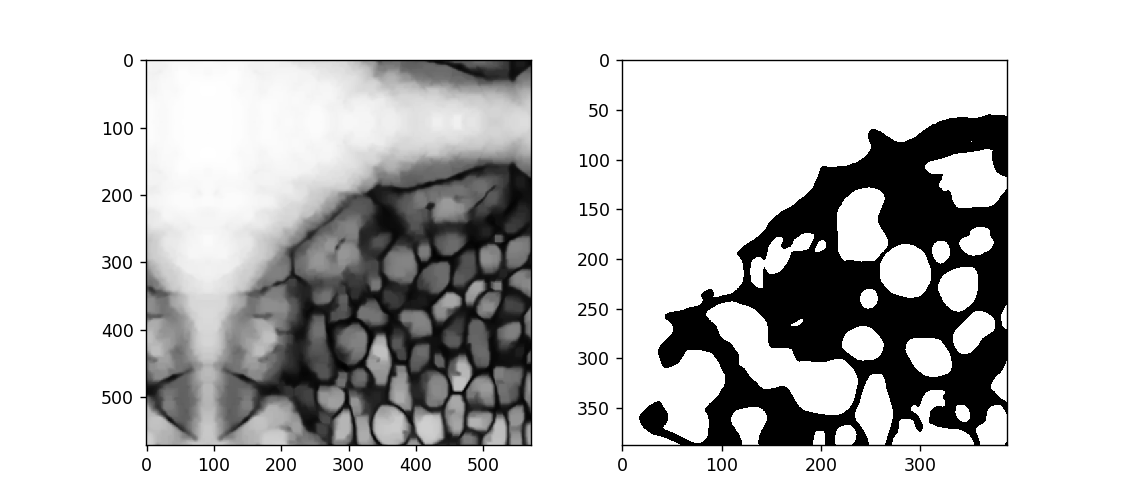

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
ax[0].imshow(image_t.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output_t.numpy()[0], cmap=plt.cm.Greys_r)